# Alanine multithermal with OPES

For detail on the OPES method see [this paper](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.041034).

Since `openmm-plumed` does not support using the potential energy as a CV (see [here](https://github.com/openmm/openmm-plumed/issues/53)), we reimplement [OPES_EXPANDED](https://www.plumed.org/doc-master/user-doc/html/_o_p_e_s__e_x_p_a_n_d_e_d.html) in OpenMM, using `CustomCVForce`. The result is not very fast, but works.

In [1]:
import numpy as np
import mdtraj as md

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [ ]:
#handy function for the model system
import bgmol

def get_model(system_name, temperature=None):
    
    model = bgmol.system_by_name(system_name.removesuffix('ModifiedPSI'))
    
    if 'ModifiedPSI' in system_name:
        extraBias_str = '100*sin(0.5*theta)^2'
        extraBias = openmm.CustomTorsionForce(extraBias_str)
        psi_angles = md.compute_psi(md.Trajectory(model.positions, model.mdtraj_topology))[0]
        for i in range(len(psi_angles)):
            extraBias.addTorsion(*psi_angles[i])
            print(f"{system_name}, adding bias on psi{psi_angles[i]}: {extraBias_str}")
        model.system.addForce(extraBias)        
    
    if temperature is not None:
        model.reinitialize_energy_model(temperature=temperature)
    
    return model

In [3]:
#setup the system

system_name = 'AlanineDipeptideVacuum'
# system_name = 'AlanineDipeptideImplicit'
# system_name = 'AlanineTetrapeptideImplicit'
model = get_model(system_name)

temp = 300
Tmin = 270
Tmax = 1000
temp_steps = 4

model.positions.shape

(22, 3)

In [4]:
#some plotting functions
from matplotlib.colors import LogNorm

def get_phi_psi(trajectory, i=-1, model=model):
    if not isinstance(trajectory, md.Trajectory):
        # if isinstance(trajectory, torch.Tensor):
        #     trajectory = assert_numpy(trajectory.view(len(trajectory), *model.positions.shape))
        trajectory = md.Trajectory(trajectory, model.mdtraj_topology)
    phi = md.compute_phi(trajectory)[1][:,i]
    psi = md.compute_psi(trajectory)[1][:,i]
    return phi, psi

def plot_rama_traj(trajectory, w=None, get_phi=False, i=-1, model=model):
    phi, psi = get_phi_psi(trajectory, i)
    plot_range = [-np.pi, np.pi]
    
    #histogram
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.title("Histogram")
    plt.hist2d(phi, psi, 60, weights=w, norm=LogNorm(), range=[plot_range,plot_range])
    plt.xlim(plot_range)
    plt.ylim(plot_range)
    plt.xlabel("$\phi$")
    plt.ylabel("$\psi$")
    plt.gca().set_box_aspect(1)
    
    #trajectory
    plt.subplot(1,2,2)
    plt.title("Trajectory")
    end = len(phi)
    plt.scatter(range(end), phi, c=psi, s=10)
    plt.xlim([0, end])
    plt.xlabel("n_iter")
    plt.ylabel("$\phi$")
    plt.gca().set_box_aspect(0.5)
    plt.show()
    
    if get_phi:
        return phi

def plot_phi_FES(phi, w=None, n_bins='auto', T_high=Tmax, T_low=Tmin, ymax=20):
    plot_range = (-np.pi, np.pi)
    hist, edges = np.histogram(phi, bins=n_bins, range=plot_range)
    fes_estimate = -np.log(np.where(hist!=0,hist/hist.max(),np.nan))
    plt.plot(edges[:-1]+(edges[1]-edges[0])/2, fes_estimate, label="direct FES")
    DeltaF_T_high = None
    DeltaF_T_low = None
    try:
        ref_file = f'FESreference/FES-{prior_name}-T{T_high}.dat'
        phi_ref, fes_ref = np.loadtxt(ref_file, usecols=(0,1), unpack=True)
        fes_ref /= (kB*T_high)
        plt.plot(phi_ref, fes_ref, label=f"reference {T_high}K", linestyle='dotted')
        ymax = max(ymax, np.amax(fes_ref))
        DeltaF_T_high = np.logaddexp.reduce(-fes_ref[phi_ref<0])-np.logaddexp.reduce(-fes_ref[phi_ref>0])
    except IOError:
        print('+++ Ref. file not found: '+ref_file+' +++')
    if w is not None:
        if n_bins == 'auto':
            n_bins = 50
        hist, edges =np.histogram(phi, bins=n_bins, range=plot_range, weights=w)
        fes_estimate = -np.log(np.where(hist!=0,hist/hist.max(),np.nan))
        plt.plot(edges[:-1]+(edges[1]-edges[0])/2, fes_estimate, label="reweighted FES")
        try:
            ref_file = f'FESreference/FES-{target_name}-T{T_low}.dat'
            phi_ref, fes_ref = np.loadtxt(ref_file, usecols=(0,1), unpack=True)
            fes_ref /= (kB*T_low)
            plt.plot(phi_ref, fes_ref, label=f"reference {T_low}K", linestyle='dotted')
            ymax = max(ymax, np.amax(fes_ref))
            DeltaF_T_low = np.logaddexp.reduce(-fes_ref[phi_ref<0])-np.logaddexp.reduce(-fes_ref[phi_ref>0])
        except IOError:
            print('+++ Ref. file not found: '+ref_file+' +++')
    plt.xlim(plot_range)
    plt.ylim(bottom=0, top=min(ymax, max(fes_estimate)))
    plt.xlabel("$\phi$")
    plt.ylabel("FES")
    plt.legend()
    plt.show()
    #references are from OPES
    if DeltaF_T_high is not None:
        print(f'DeltaF at {T_high:4g}K: {DeltaF_T_high:.3f}')
    if DeltaF_T_low is not None:
        print(f'DeltaF at {T_low:4g}K: {DeltaF_T_low:.3f}')
    DeltaF = -np.log(np.count_nonzero(phi>0) / np.count_nonzero(phi<0))
    print('  DeltaF direct: %.3f' % DeltaF)
    if w is not None:
        DeltaF = -np.log(np.sum(w[phi>0]) / np.sum(w[phi<0]))
        print('DeltaF reweight: %.3f' % DeltaF)

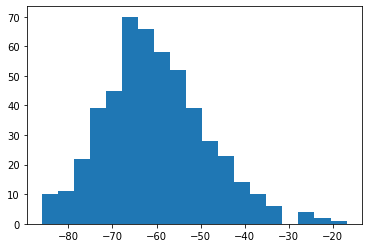

Temperatures: [ 270.    417.74  646.33 1000.  ]
Initial DeltaFs: [-6.68 16.94 32.21 42.07]
Mean energy: -60.10478680419922
CPU times: user 10.9 s, sys: 1.9 s, total: 12.8 s
Wall time: 12.2 s


In [5]:
%%time

#initialize useful variables
beta = 1/temp/kB
temperatures = np.geomspace(Tmin, Tmax, temp_steps) 
df_size = temp_steps
running_df = np.zeros(temp_steps)
rct = 0
counter = 1

#setup things for MD run
pace = 500
model = get_model(system_name)
integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 1./unit.picosecond, 2.*unit.femtosecond)
simulation = openmm.app.Simulation(model.topology, model.system, integrator)
simulation.context.setPositions(model.positions)

#equilibrate the system and intialize the DeltaFs
n_equil = 500
print('equilibration...', end='\r')
simulation.minimizeEnergy()
simulation.step(pace*n_equil)
ener = np.zeros(n_equil)
for n in range(n_equil):
    simulation.step(pace)
    ener[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    print(f'sampling...  {(n+1)/n_equil:.1%}', end='\r')
mean_ener = np.mean(ener)
for i in range(df_size):
    running_df[i] = (temp/temperatures[i]-1) * mean_ener

equil_pos = simulation.context.getState(getPositions=True).getPositions()

#print some info
with np.printoptions(precision=2):
    print('Temperatures:', temperatures)
    # print('Initial DeltaFs:', running_df)
print('Mean energy:', mean_ener)
print()

In [8]:
# setup biased model using CustomCVForce
import copy

model = get_model(system_name)
robust_bias = False #slower, set True only if the bias becomes nan at beginning of simulation

if isinstance(model.system.getForces()[-1], openmm.CMMotionRemover):
    num_forces = model.system.getNumForces()-1
else:
    assert False, 'last force was supposed to be the CMMotionRemover'

# define bias
ene_str = '('+'+'.join([f'u{k}' for k in range(num_forces)])+')'
if not robust_bias:
    bias_str = '-1/beta*log((0'
    for i in range(df_size):
        bias_str += f'+exp(beta*((1-temp/{temperatures[i]})*{ene_str}+df{i}))'
    bias_str += f')/{df_size}); beta={beta}; temp={temp}'
else:
    # use LogSumExp for stability, but much slower
    bias_str = f'-1/beta*(diffMax+log(1/{df_size}*(0' #this is with LogSumExp
    for i in range(df_size):
        bias_str += f'+exp(diff{i}-diffMax)'
    bias_str += f'))); diffMax=max(diff0,diffMax1)'
    for i in range(1, df_size-2):
        bias_str += f'; diffMax{i}=max(diff{i},diffMax{i+1})'
    bias_str += f'; diffMax{df_size-2}=max(diff{df_size-2},diff{df_size-1})'
    for i in range(df_size):
        bias_str += f'; diff{i}=beta*((1-temp/{temperatures[i]})*{ene_str}+df{i})'
    bias_str += f'; beta={beta}; temp={temp}'
print('Bias potential:', bias_str)

# add bias to forces
bias_potential = openmm.CustomCVForce(bias_str)
for i in range(df_size):
    bias_potential.addGlobalParameter(f'df{i}', running_df[i])
ener_group = 0
bias_group = 1
for k in range(num_forces):
    model.system.getForce(k).setForceGroup(ener_group)
    bias_potential.addCollectiveVariable(f'u{k}', copy.deepcopy(model.system.getForces()[k]))
model.system.addForce(bias_potential)
model.system.getForce(model.system.getNumForces()-1).setForceGroup(bias_group)

model.system.getForces()

-1/beta*log((0+exp(beta*((1-temp/270.0)*(u0+u1+u2+u3)+df0))+exp(beta*((1-temp/417.74299502515026)*(u0+u1+u2+u3)+df1))+exp(beta*((1-temp/646.330407009565)*(u0+u1+u2+u3)+df2))+exp(beta*((1-temp/1000.0)*(u0+u1+u2+u3)+df3)))/4); beta=0.40090785014242014; temp=300


[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7fbaf9adf030> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7fbaf9affed0> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7fbaf9aff0f0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7fbaf9affd80> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7fbaf9ad7db0> >,
 <openmm.openmm.CustomCVForce; proxy of <Swig Object of type 'OpenMM::CustomCVForce *' at 0x7fbaf9ad79c0> >]

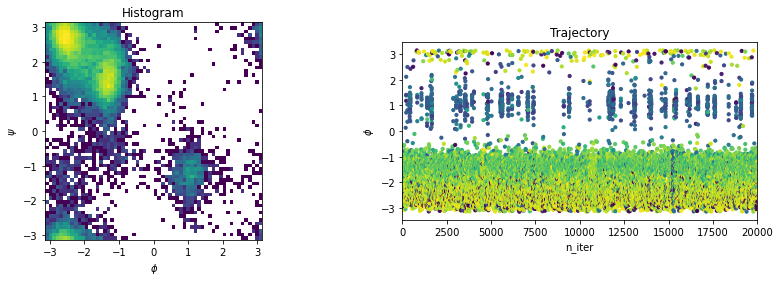

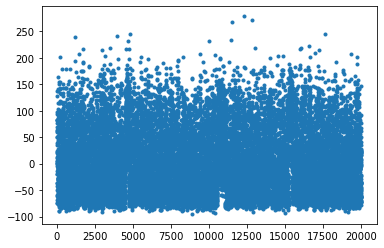

CPU times: user 33min 56s, sys: 10min 4s, total: 44min 1seta*df[-1] = 4.009273184036356
Wall time: 33min 55s


In [9]:
%%time
# OPES biased MD run

n_iter = 20_000
integrator = openmm.LangevinIntegrator(temp*unit.kelvin, 1./unit.picosecond, 2.*unit.femtosecond)
simulation = openmm.app.Simulation(model.topology, model.system, integrator)
simulation.context.setPositions(equil_pos)

data = np.full((n_iter, *model.positions.shape), np.nan)
ener = np.full(n_iter, np.nan) # needed for reweighting
bias = np.full(n_iter, np.nan) # needed for reweighting
all_df = np.full((n_iter, len(running_df)), np.nan)
all_rct = np.full(n_iter, np.nan)

for n in range(n_iter):
    simulation.step(pace)
    data[n] = simulation.context.getState(getPositions=True).getPositions().value_in_unit(unit.nanometers)
    ener[n] = simulation.context.getState(getEnergy=True, groups={ener_group}).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    bias[n] = simulation.context.getState(getEnergy=True, groups={bias_group}).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    ##### update DeltaFs
    increment = 1/beta*np.log1p(np.exp(beta*(bias[n]-rct))/counter)
    for i in range(df_size):
        diff_i = beta*((1-temp/temperatures[i])*ener[n]+bias[n]-rct+running_df[i])
        running_df[i] += increment - 1/beta*np.log1p(np.exp(diff_i)/counter)
        simulation.context.setParameter(f'df{i}', running_df[i])
    counter += 1
    rct += increment + 1/beta*np.log1p(-1/counter)
    ##### 
    all_df[n] = running_df
    all_rct[n] = rct
    # print info
    if (n+1) % 1000 == 0:
        clear_output(wait=True)
        plot_rama_traj(data[:n+1])
        # plt.plot(ener, '.')
        # plt.show()
    print(f'sampling...  {n/n_iter:.2%}, beta*df[0] = {beta*running_df[0]}, beta*df[-1] = {beta*running_df[-1]}', end='\r')
#     print(f'sampling...  {n/n_iter:.1%}  bias={bias[n]}',end='\r')

## check results

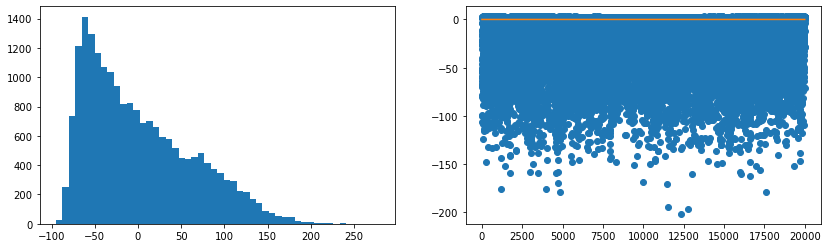

array([-2.68466349,  5.26315808,  6.73389416,  4.00927318])

In [10]:
# more plotting
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hist(ener, bins='auto')
plt.xlabel('potential energy')

plt.subplot(1,2,2)
plt.plot(bias, '.')
plt.axhline(0, c='r', ls=':')
plt.xlim(0, len(bias))
plt.ylabel('bias potential')
plt.xlabel('time')
plt.show()

plt.plot(all_rct, label='rct')
for i in range(df_size):
    plt.plot(all_df[:,i], label=f'$\Delta F$({temperatures[i].2f})')
plt.xlabel('time')
plt.ylabel(f'$\Delta F(T)$ from T={temp:.2f}')
plt.legend()
plt.show()
print(f'DeltaF_{Tmax}-{temp}: {-beta*running_df[-1]:g}')
print(f'DeltaF_{Tmax}-{Tmin}: {beta*(running_df[0]-running_df[-1]):g}')

def biasFunc(u, df=running_df):
    return -1/beta*(np.logaddexp.reduce([beta*((1-temp/temperatures[k])*u+df[k]) for k in range(df_size)])-np.log(df_size))
plt.scatter(ener, bias, marker='.', c=range(len(bias)))
s = ener.std()/4
ener_range = np.linspace(min(ener)-s, max(ener)+s, 100)
plt.plot(ener_range, biasFunc(ener_range, df=all_df[-1,:]), ls='--', label='final bias')
plt.plot(ener_range, biasFunc(ener_range, df=all_df[0,:]), ls='--', label='initial bias')
plt.xlim(ener_range[[0,-1]])
plt.ylabel('Bias potential')
plt.xlabel('Potential energy')
plt.legend()
plt.show()

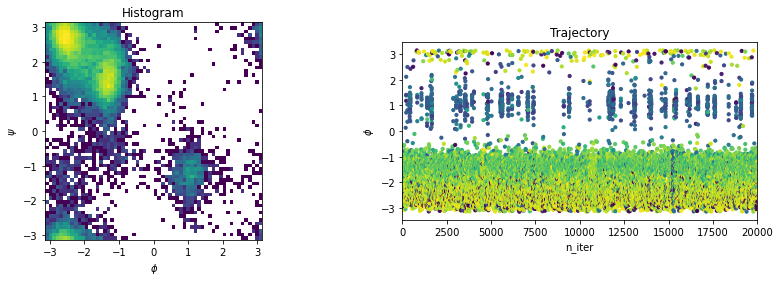

+++ Ref. file not found: ../FESreference/FESNone-AlanineDipeptideVacuum.dat +++


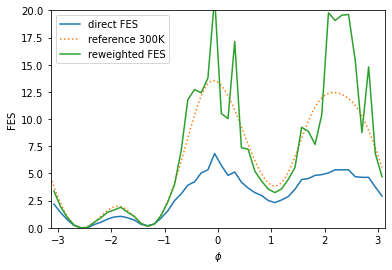

DeltaF at  300K: 4.650
  DeltaF direct: 2.732
DeltaF reweight: 4.047


In [12]:
phi = plot_rama_traj(data, get_phi=True)
plot_FES(phi, w=np.exp(beta*bias), n_bins=50)

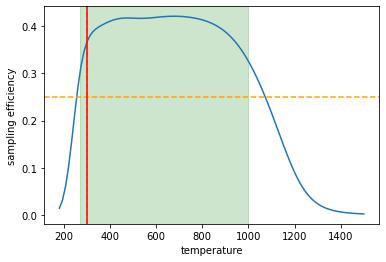

Sampling efficiency at 300K: 3.671570e-01
 Effective sample size 300K: 5507.35


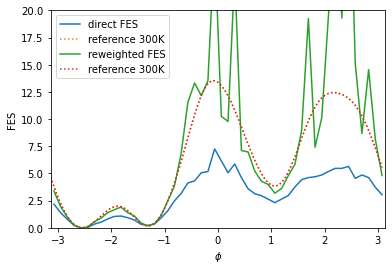

DeltaF at  300K: 4.650
DeltaF at  300K: 4.650
  DeltaF direct: 2.779
DeltaF reweight: 4.136


In [14]:
transient = 5_000
myT = 300
myphi = phi[transient:]
mybias = bias[transient:]
myener = ener[transient:]

def sampling_efficiency(logw):
    return np.exp(2*np.logaddexp.reduce(logw)-np.logaddexp.reduce(2*logw))/len(logw)

temp_range = np.linspace(Tmin/1.5, Tmax*1.5, 100)
SEs = np.array([ sampling_efficiency(beta*((1-temp/t)*myener+mybias)) for t in temp_range])
plt.plot(temp_range, SEs)
plt.axhline(1/len(temperatures), ls='--', c='orange')
plt.axvspan(Tmin, Tmax, color='green', alpha=0.2)
plt.axvline(x=temp, ls='--', c='orange')
plt.axvline(x=myT, c='red')
plt.xlabel("temperature")
plt.ylabel("sampling efficiency")
plt.show()

logw = beta * ((1 - temp / myT) * myener + mybias)
print(f'Sampling efficiency at {myT}K: {sampling_efficiency(logw):e}')
print(f' Effective sample size {myT}K: {sampling_efficiency(logw)*len(logw):g}')

plot_FES(myphi, w=np.exp(logw), n_bins=50, temp=temp, rew_temp=myT)